## Botnet Detection
-----

* The CTU-13 is a dataset of botnet traffic that was captured in the CTU University, Czech Republic, in 2011. The goal of the dataset was to have a large capture of real botnet traffic mixed with normal traffic and background traffic. The CTU-13 dataset consists in thirteen captures (called scenarios) of different botnet samples. On each scenario we executed a specific malware, which used several protocols and performed different actions, please check the following link for more information.
https://mcfp.weebly.com/the-ctu-13-dataset-a-labeled-dataset-with-botnet-normal-and-background-traffic.html

* Each scenario was captured in a pcap file that contains all the packets of the three types of traffic. These pcap files were processed to obtain other type of information, such as NetFlows, WebLogs, etc. The first analysis of the CTU-13 dataset used unidirectional NetFlows to represent the traffic and to assign the labels. These unidirectional NetFlows should not be used because they were outperformed by our second analysis of the dataset, which used bidirectional NetFlows. The bidirectional NetFlows have several advantages over the directional ones.

* Dataset source: https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-42/

### Loading Packages and Dependencies
-----

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

### Loading Dataset
----

In [2]:
dataset = pd.read_csv('D:\\Botnet Detection\\capture20110810.binetflow.2format')
dataset = dataset[dataset['Label'].str.contains('Botnet')] #Getting the bot net data
print('Rows:',dataset.shape[0], 'Columns:', dataset.shape[1])
dataset.sample(5)

Rows: 40961 Columns: 33


,SrcAddr,DstAddr,Proto,Sport,Dport,State,sTos,dTos,SrcWin,DstWin,...,SAppBytes,DAppBytes,Dur,TotPkts,TotBytes,TotAppByte,Rate,SrcRate,DstRate,Label
2625022,147.32.84.165,147.32.80.9,udp,2077,53,CON,0.0,0.0,NaN,NaN,...,28,28,25.923828,2,140,56,0.038575,0.0,0.0,flow=From-Botnet-V42-UDP-DNS
1492205,147.32.84.165,192.228.79.201,udp,2079,53,CON,0.0,0.0,NaN,NaN,...,35,495,0.175091,2,614,530,5.711316,0.0,0.0,flow=From-Botnet-V42-UDP-DNS
1791248,147.32.84.165,204.93.160.141,udp,2077,53,CON,0.0,0.0,NaN,NaN,...,43,129,0.161992,2,256,172,6.173144,0.0,0.0,flow=From-Botnet-V42-UDP-DNS
1734922,147.32.84.165,202.12.27.33,udp,2079,53,CON,0.0,0.0,NaN,NaN,...,30,284,0.023075,2,398,314,43.336945,0.0,0.0,flow=From-Botnet-V42-UDP-DNS
1428214,147.32.84.165,198.41.0.4,udp,2079,53,CON,0.0,0.0,NaN,NaN,...,34,426,0.024109,2,544,460,41.478287,0.0,0.0,flow=From-Botnet-V42-UDP-DNS


In [39]:
dataset['Label'].nunique()

68

### Checking Missing Values
----

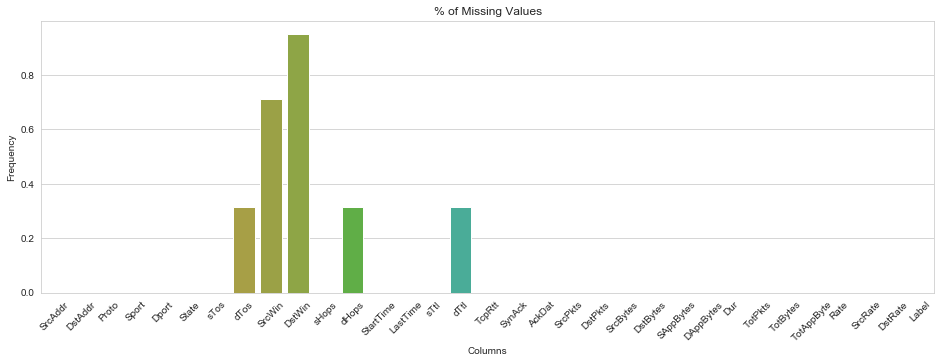

In [3]:
#Visualizing the Missing value
plt.figure(figsize=(16,5))
sns.set_style('whitegrid')
plt.title('% of Missing Values')
sns.barplot(x=dataset.isnull().mean().index, y=dataset.isnull().mean().values)
plt.xlabel('Columns')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.show()

# Removed all the columns with missing value > 30%
dataset = dataset.loc[:, dataset.isnull().mean() < 0.3] 

### Feature Engineering
-----

In [4]:
dataset = dataset.astype({"Proto":'category',"Sport":'category',"Dport":'category',"State":'category','StartTime':'datetime64[s]','LastTime':'datetime64[s]'}) # Changing the datatype of the columns
dataset['duration'] = abs(dataset['LastTime'].dt.second - dataset['StartTime'].dt.second) # getting duration from the columns 'LastTime' and 'StartTime'
dataset.drop(columns=['SrcAddr','DstAddr','LastTime','StartTime'],inplace=True) #Dropping the column SrcAddr and DstAddr since they contain unique ip addresses

### Data Visualization
---

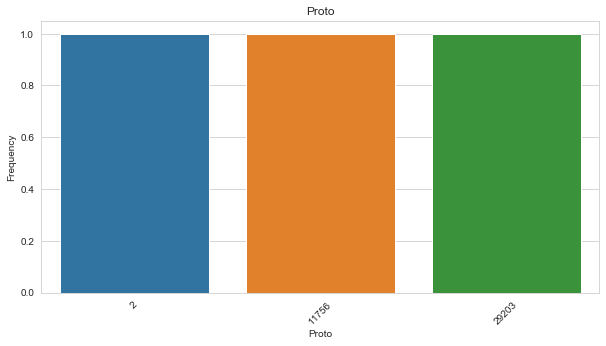

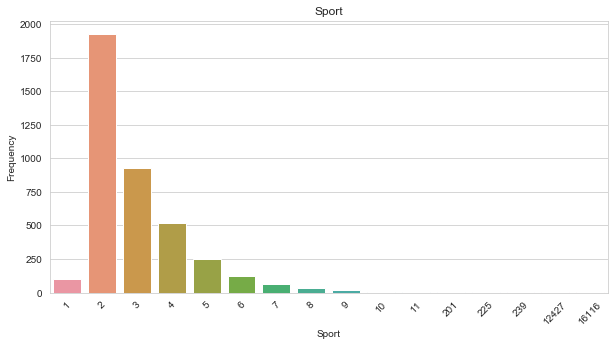

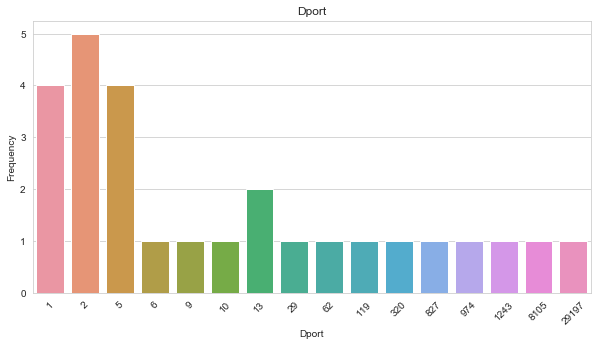

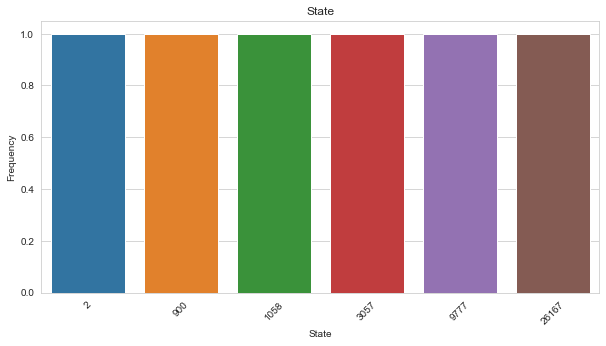

In [6]:
#Analyzing categorical valriable
def barchart(columns):
    plt.figure(figsize=(10,5))
    plt.title(f'{columns}')
    sns.countplot(x=dataset[f'{columns}'].value_counts().values)
    plt.xlabel(f'{columns}')
    plt.xticks(rotation=45)
    plt.ylabel('Frequency')
    plt.show()
    
categorical_columns = dataset.select_dtypes(exclude=['int64', 'float64']).columns.values      
for column in categorical_columns:
    if column != 'Label':
        barchart(column)

### Model Building
----

In [8]:
dataset = pd.get_dummies(dataset,columns=categorical_columns[:-1],drop_first=True)
X = dataset.loc[:, dataset.columns != 'Label']
y = dataset.loc[:, dataset.columns == 'Label']

In [11]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.2,random_state=45)

In [18]:
descision_tree_model = DecisionTreeClassifier()
descision_tree_model.fit(Xtrain,ytrain)
prediction = descision_tree_model.predict(Xtest)
print('Decision Accuracy Score:',round(accuracy_score(ytest,prediction)*100),'%')

Accuracy Score: 99.0 %


In [23]:
multinomial_naive_bayes = GaussianNB()
multinomial_naive_bayes.fit(Xtrain,ytrain)
prediction_naive = multinomial_naive_bayes.predict(Xtest)
print('Naive Bayes Accuracy Score:',round(accuracy_score(ytest,prediction_naive)*100),'%')

Naive Bayes Accuracy Score: 94.0 %


In [26]:
Logistic_model = LogisticRegression(C=1000)
Logistic_model.fit(Xtrain,ytrain)
prediction_Logistic = Logistic_model.predict(Xtest)
print('Logistic Regression Accuracy Score:',round(accuracy_score(ytest,prediction_Logistic)*100),'%')

Logistic Regression Accuracy Score: 84.0 %


In [29]:
Random_forest_model = RandomForestClassifier(class_weight='balanced')
Random_forest_model.fit(Xtrain,ytrain)
prediction_Random_forest_model = Random_forest_model.predict(Xtest)
print('Random Forest Accuracy Score:',round(accuracy_score(ytest,prediction_Random_forest_model)*100),'%')

Random Forest Accuracy Score: 99.0 %
